##### TP integrador
Download Dataset here:
[Buenos Aires public bike system](https://www.kaggle.com/datasets/fgarciablanco/buenos-aires-public-bike-system-dataset?resource=download)



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import HTML


In [2]:
HTML('<a href="https://www.kaggle.com/datasets/fgarciablanco/buenos-aires-public-bike-system-dataset?resource=download" target="_blank">Download Dataset</a>')

In [3]:
df = pd.read_csv('./Datasets/recorridos-realizados-2018.csv', encoding='latin-1')
len(df)

1457509

In [5]:
df.head(2)
#df.info()

,bici_id_usuario,bici_Fecha_hora_retiro,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad,bici_direccion,bici_pais
0,15728,26/05/2018 15:32:07,0:08:52,F. J. Santamaría de Oro,125,Acuña de Figueroa,54,M,28.0,TTE BENJAMIN MATIENZO,Argentina
1,26531,26/05/2018 3:42:41,0:30:49,Yatay,121,Hospital Garrahan,107,M,26.0,LAVALLE,Argentina


In [6]:
# Convertir fecha_hora_retiro a datetime

df.bici_Fecha_hora_retiro = df.bici_Fecha_hora_retiro.apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))
df['date'] = df.bici_Fecha_hora_retiro.apply(lambda x: x.replace(minute=0, second=0))


Text(0.5, 1.0, 'Alquiler de bicis Mayo 2015 - Julio 2018')

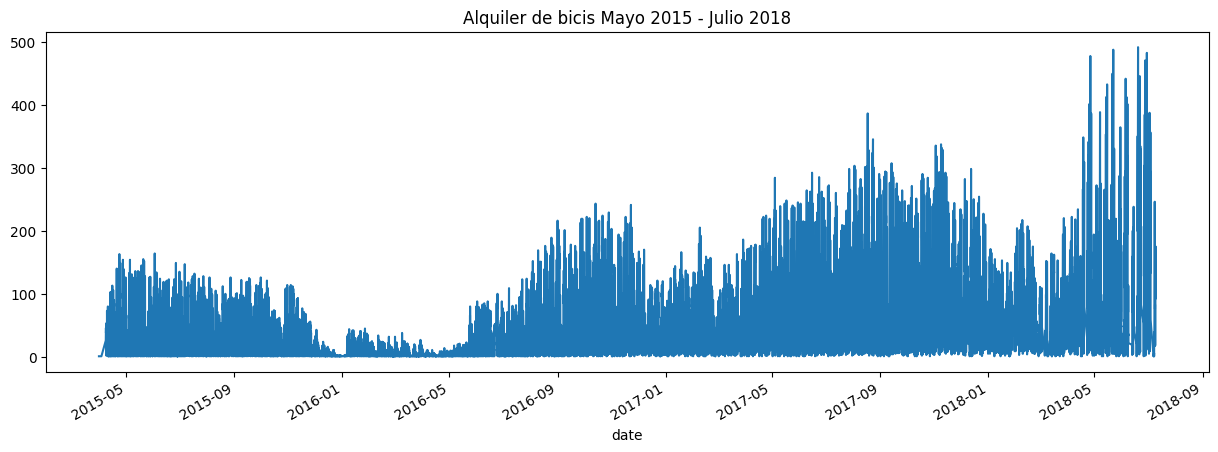

In [7]:
plt.figure(figsize=(15,5))
df.groupby('date').bici_id_usuario.count().plot()
plt.title('Alquiler de bicis Mayo 2015 - Julio 2018')

In [8]:
# Obtengo minutos de alquiler de bici

parse_duration = lambda duration_str: timedelta(
    hours=int(duration_str.split(':')[0]),
    minutes=int(duration_str.split(':')[1]) if len(duration_str.split(':')) >=2 else 0,
    seconds=int(duration_str.split(':')[2]) if len(duration_str.split(':')) >=3 else 0
)

df['bici_tiempo_uso_delta'] = df['bici_tiempo_uso'].apply(lambda x: parse_duration(x))
df['total_minutes'] = df['bici_tiempo_uso_delta'].dt.total_seconds() / 60

In [9]:
min(df.total_minutes), max(df.total_minutes)

(8.0, 47176.0)

Text(0.5, 1.0, 'Boxplot: duración de alquiler de bici (excluyendo outliers)')

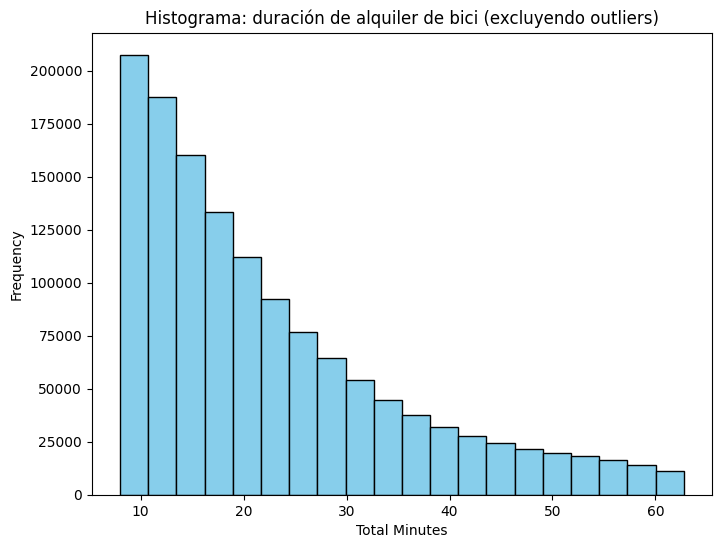

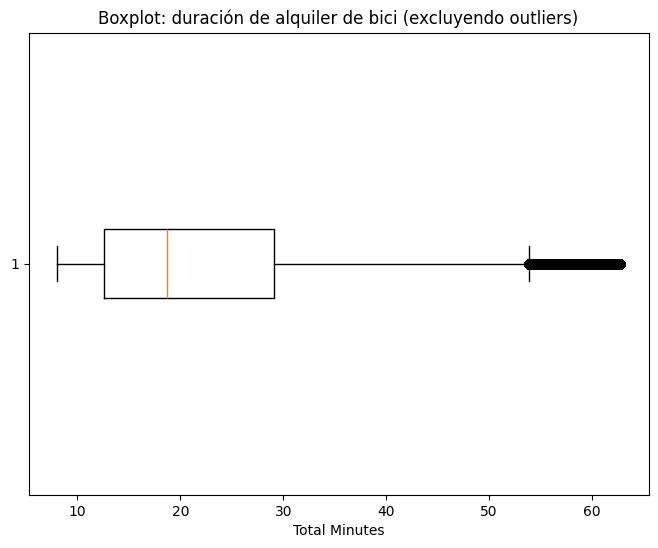

In [10]:
# Calculo quantiles
Q1 = df['total_minutes'].quantile(0.25)
Q3 = df['total_minutes'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtramos outliers
filtered_df = df[(df['total_minutes'] >= lower_bound) & (df['total_minutes'] <= upper_bound)]

plt.figure(figsize=(8, 6))
plt.hist(filtered_df['total_minutes'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Total Minutes')
plt.ylabel('Frequency')
plt.title('Histograma: duración de alquiler de bici (excluyendo outliers)')

plt.figure(figsize=(8, 6))
plt.boxplot(filtered_df['total_minutes'], vert=False)
plt.xlabel('Total Minutes')
plt.title('Boxplot: duración de alquiler de bici (excluyendo outliers)')


In [11]:
s = df.groupby('date').bici_id_usuario.count()

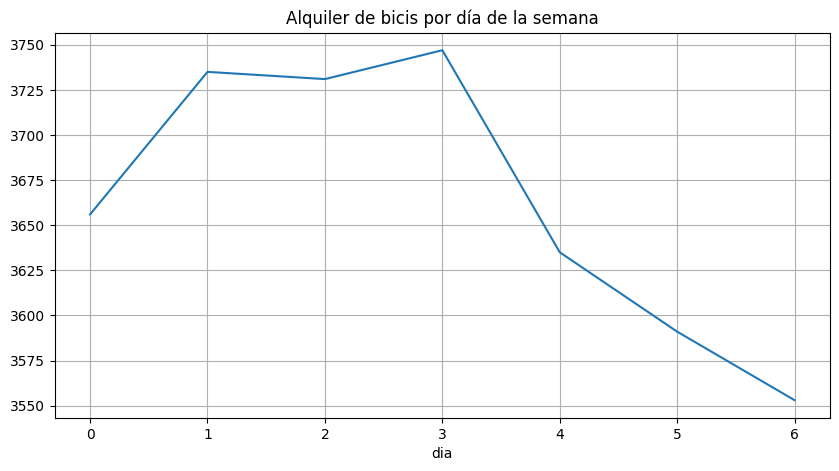

In [12]:
# Visualización por día de la semana

plt.figure(figsize=(10,5))
a = s.reset_index()
a['dia'] = a.date.apply(lambda x: x.weekday())
a.groupby('dia').bici_id_usuario.count().plot()
plt.xticks(list(range(7)))
plt.title('Alquiler de bicis por día de la semana')
plt.grid()


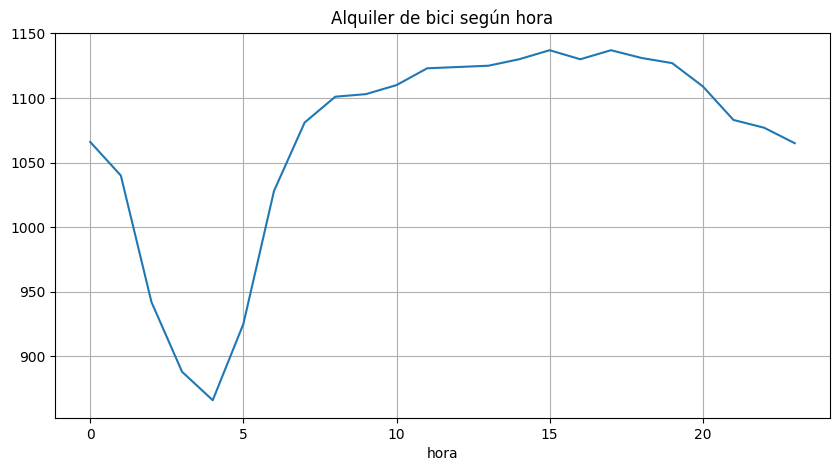

In [13]:
plt.figure(figsize=(10,5))
a['hora'] = a.date.apply(lambda x: x.hour)
a.groupby('hora').bici_id_usuario.count().plot()
plt.xticks()
plt.title('Alquiler de bici según hora')
plt.grid()


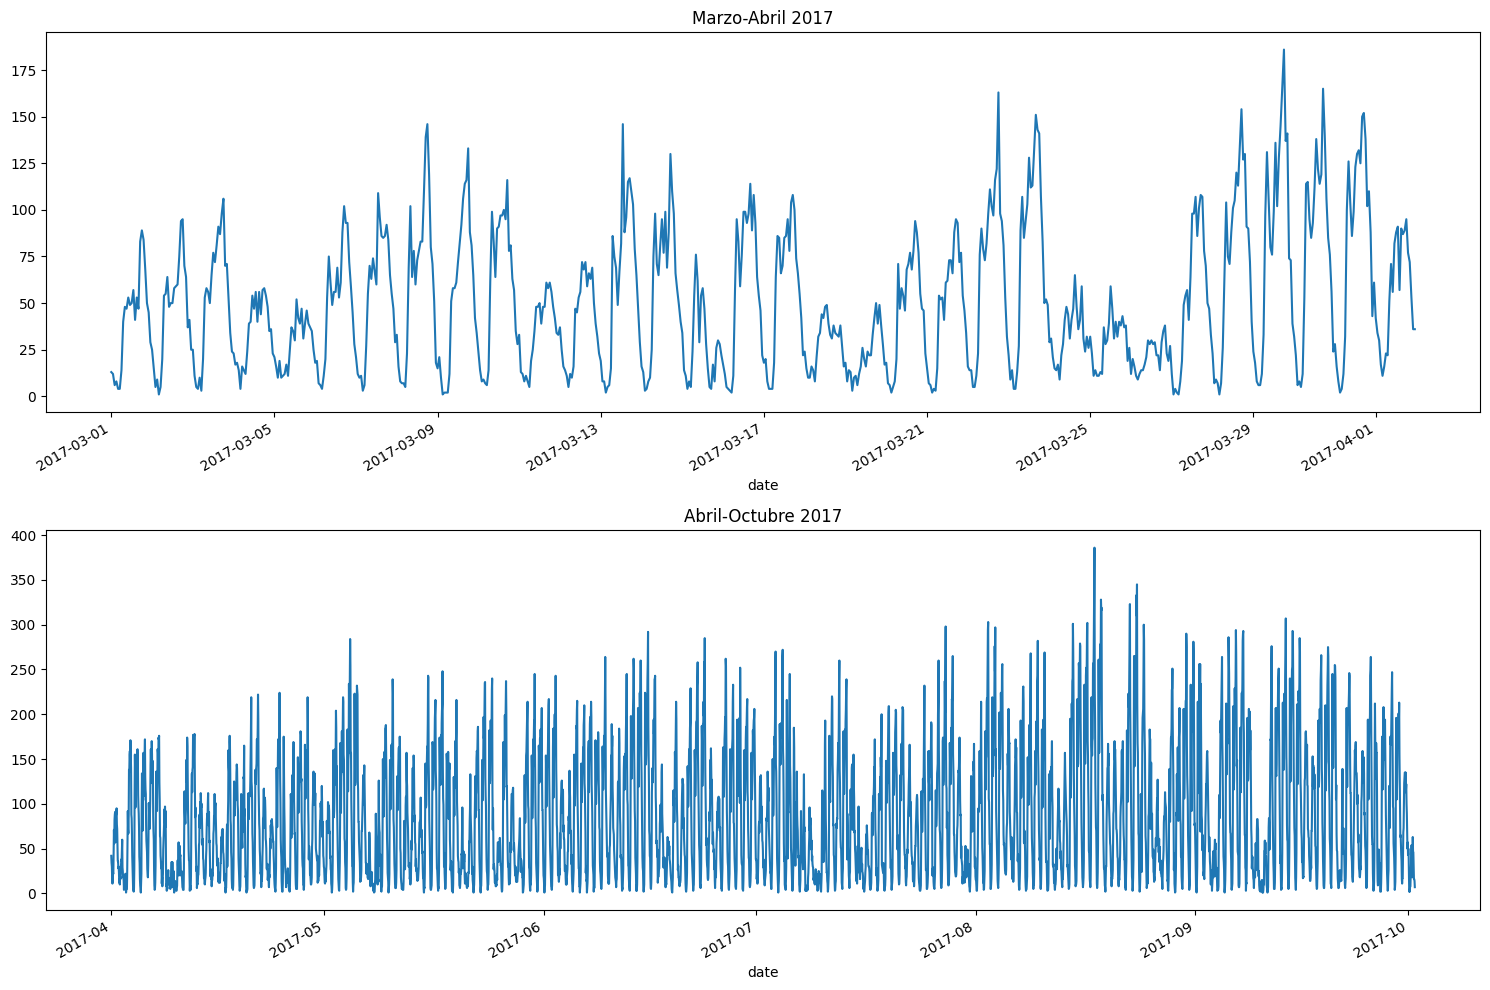

In [14]:
s = df.groupby('date').bici_id_usuario.count()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

## Visualización un mes de datos
s['2017-03-01': '2017-04-01'].plot(ax=axes[0])
axes[0].set_title('Marzo-Abril 2017')

# Visualización 6 meses de datos
s['2017-04-01': '2017-10-01'].plot(ax=axes[1])
axes[1].set_title('Abril-Octubre 2017')

plt.tight_layout()
plt.show()

#### Análisis
El dataset contiene información sobre el alquiler de bicicletas en la Ciudad de Buenos Aires durante el período Marzo 2015 - Julio 2018.

* En el gráfico de toda la serie se observa una tendencia alcista a partir del 2016. Se trata de una serie univariada y discreta y no estacionaria. Esta tendencia alcista parece deberse a un incremento en la adopción del servicio. 
* Graficamos también por día de la semana y por hora. Se observa cómo decae el alquiler durante los fines de semana y cómo la mayor cantidad de alquileres se da entre las 08 y las 20 horas, con un pico a la 18/19. Esto coincide con el horario en que la gente entra y sale de trabajar. Mientras que el alquiler cae drásticamente durante las horas de la madrugada.
* Graficando un mes de datos podemos observar cierta estacionalidad dada por los picos y valles entre semanas. 
* Graficando seis meses de datos en el período de Abril 2017 - Octubre 2017 vemos que la estacionalidad se mantiene.

#### Modelo aditivo de cuatro componentes: seasonal, tendencia, ciclica, error

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [16]:
df.head(2)

,bici_id_usuario,bici_Fecha_hora_retiro,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad,bici_direccion,bici_pais,date,bici_tiempo_uso_delta,total_minutes
0,15728,2018-05-26 15:32:07,0:08:52,F. J. Santamaría de Oro,125,Acuña de Figueroa,54,M,28.0,TTE BENJAMIN MATIENZO,Argentina,2018-05-26 15:00:00,0 days 00:08:52,8.866667
1,26531,2018-05-26 03:42:41,0:30:49,Yatay,121,Hospital Garrahan,107,M,26.0,LAVALLE,Argentina,2018-05-26 03:00:00,0 days 00:30:49,30.816667


In [17]:
daily_rentals = df.groupby(pd.Grouper(key='date', freq='D'))['total_minutes'].sum().reset_index()

In [21]:
dr = daily_rentals.set_index('date')

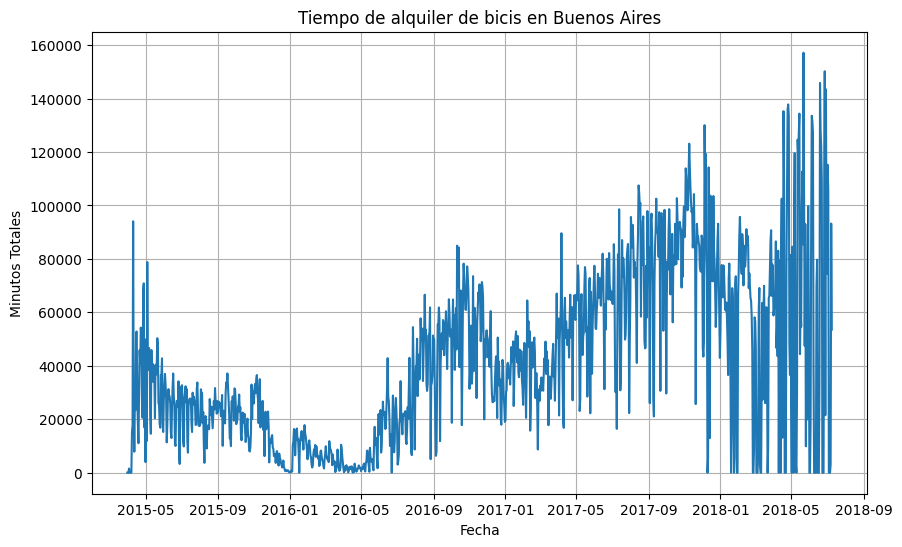

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(dr.index, dr['total_minutes'])
plt.title('Tiempo de alquiler de bicis en Buenos Aires')
plt.xlabel('Fecha')
plt.ylabel('Minutos Totales')
plt.grid(True)

In [27]:
result = seasonal_decompose(dr['total_minutes'], model='additive')

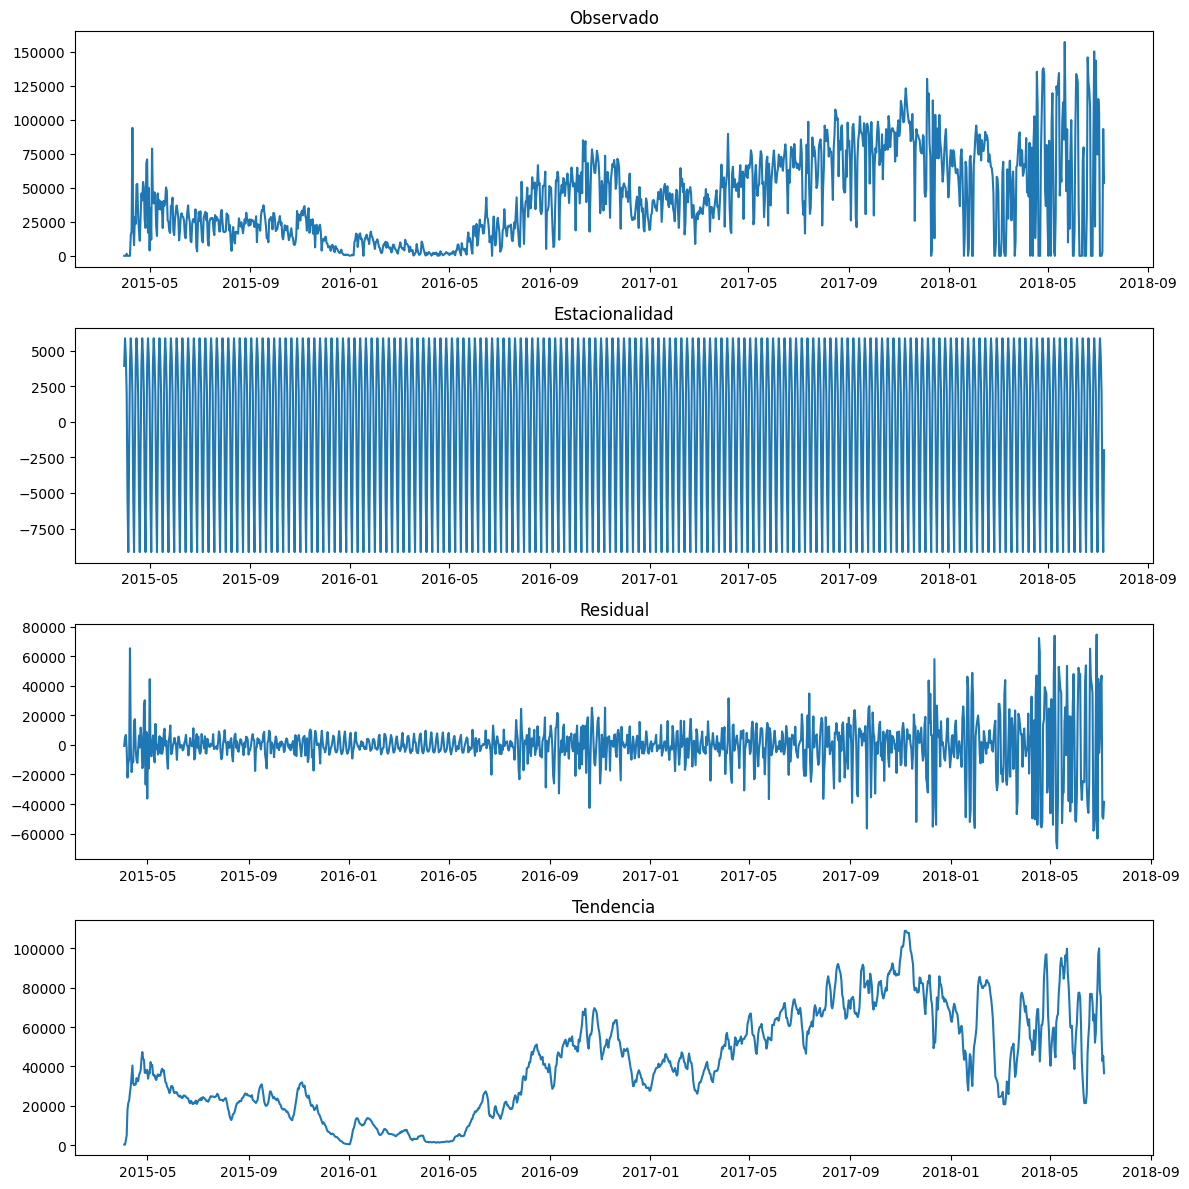

In [39]:
plt.figure(figsize=(12,12))

plt.subplot(4,1,1)
plt.plot(result.observed)
plt.title('Observado')

plt.subplot(4,1,2)
plt.plot(result.seasonal)
plt.title('Estacionalidad')

plt.subplot(4,1,3)
plt.plot(result.resid)
plt.title('Residual')

plt.subplot(4,1,4)
plt.plot(result.trend)
plt.title('Tendencia')

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


daily_rent = df.set_index('date')
daily_rent = daily_rent.resample('D').bici_id_usuario.count()


In [ ]:
result = seasonal_decompose(daily_rent, model='additive')

plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(result.trend)
plt.title('Tendencia')

plt.subplot(4, 1, 2)
plt.plot(result.seasonal)
plt.title('Estacionalidad')

plt.subplot(4, 1, 3)
plt.plot(result.resid)
plt.title('Residuos')

plt.subplot(4, 1, 4)
plt.plot(result.observed)
plt.title('Observado')

plt.tight_layout()
plt.show()

Extraer la tendencia y ajustar un modelo determinístico. Explicar su relación con el
contexto. Obtener conclusiones acerca de la validez del modelo.
● Entrega clase 4: Evaluar si la serie original es estacionaria. Aplicar transformaciones
(preprocesamiento), graficar autocorrelación, autocorrelación parcial y extraer conclusiones.